In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quantecon import LQ
from collections import namedtuple
from DynLinEcon import DLE
from math import sqrt
%matplotlib inline

# Cattle Cycles

This notebook uses the DLE class to construct the "Cattle Cycles" model of Rosen, Murphy and Scheinkman (1994) (RMS1994). The paper uses a partial equilibrium model to interpret the cyclicality of US cattle stocks.

### The Model

The model uses a static linear demand curve and a "time-to-grow" structure for cattle. Let $p_t$ be the price of slaughtered beef, $m_t$ the cost of preparing an animal for slaughter, $h_t$ the holding cost for a mature animal, $\gamma_1 h_t$ the holding cost for a yearling, and $\gamma_0 h_t$ the holding cost for a calf.

The cost processes $\{h_t, m_t \}_{t=0}^\infty$ are exogenous, while the price process $\{p_t \}_{t=0}^\infty$ is determined by a rational expectations equilibrium.

Let $x_t$ be the breeding stock, and $y_t$ be the total stock of cattle. The law of motion for the breeding stock is:
$$ x_t = (1-\delta)x_{t-1} + gx_{t-3} - c_t $$
where $g < 1$ is the number of calves that each member of the breeding stock has each year, and $c_t$ is the number of cattle slaughtered.

The total head count of cattle is:
$$ y_t = x_t + gx_{t-1} + gx_{t-2}$$
(the sum of adults, calves and yearlings, respectively).

A representative farmer chooses $\{c_t, x_t\}$ to maximize:
$$ \mathbb{E}_0 \sum_{t=0}^\infty \beta^t \{p_tc_t - h_tx_t - \gamma_0 h_t(gx_{t-1}) - \gamma_1 h_t(gx_{t-2}) - m_tc_t - \frac{\psi_1}{2}x_t^2 - \frac{\psi_2}{2}x_{t-1}^2 - \frac{\psi_3}{2}x_{t-3}^2 - \frac{\psi_4}{2}c_t^2 \}$$

subject to the law of motion for $x_t$, taking as given the stochastic laws of motion for the exogenous processes, the equilibrium price process, and the initial state [$x_{-1},x_{-2},x_{-3}$]. (The $\psi_j$ parameters represent very small quadratic costs.)

Demand is government by $c_t = a_0 - a_1p_t + \tilde d_t$ where $\tilde d_t$ is a stochastic process with mean zero, representing a demand shifter.

### Mapping into HS2013 framework

#### Preferences

We set $\Lambda = 0, \Delta_h = 0, \Theta_h = 0, \Pi = \alpha_1^{-\frac{1}{2}}$ and $b_t = \Pi \tilde d_t + \Pi \alpha_0$.

With these settings, the FOC for the household's problem becomes the demand curve of the "Cattle Cycles" model.

#### Technology

To capture the law of motion for cattle, we set:
$$ \Delta_k = 
\left[ {\begin{array}{ccc}
   (1-\delta) & 0 & g \\ 1 & 0 & 0 \\ 0 & 1 & 0
   \end{array} } 
   \right]
, \Theta_k = 
\left[ {\begin{array}{c}
   1 \\ 0 \\ 0
   \end{array} } 
   \right]
$$
(where $i_t = - c_t$)

To capture the production of cattle, we set:
$$\Phi_c = 
\left[ {\begin{array}{c}
   1 \\ f_1 \\ 0 \\ 0 \\ -f_7
   \end{array} } 
   \right]
   \Phi_g = 
\left[ {\begin{array}{cccc}
   0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1
   \end{array} } 
   \right]
   \Phi_i = 
\left[ {\begin{array}{c}
   1 \\ 0 \\ 0 \\ 0 \\ 0
   \end{array} } 
   \right]
   \Gamma = 
\left[ {\begin{array}{ccc}
   0 & 0 & 0 \\ f_1(1-\delta) & 0 & g f_1 \\ f_3 & 0 & 0 \\ 0 & f_5 & 0 \\ 0 & 0 & 0
   \end{array} } 
   \right]
$$

#### Information
We set:
$$A_{22} = 
\left[ {\begin{array}{cccc}
   1 & 0 & 0 & 0\\ 0 & \rho_1 & 0 & 0 \\ 0 & 0 & \rho_2 & 0 \\ 0 & 0 & 0 & \rho_3
   \end{array} } 
   \right]
,   C_2 = 
\left[ {\begin{array}{ccc}
   0 & 0 & 0\\ 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 15
   \end{array} } 
   \right]
,   U_b = 
\left[ {\begin{array}{cccc}
   \Pi \alpha_0 & 0 & 0 & \Pi
   \end{array} } 
   \right]
,   U_d = 
\left[ {\begin{array}{c}
   0 \\ f_2 U_h \\ f_4 U_h \\ f_6 U_h \\ f_8 U_h
   \end{array} } 
   \right]
   $$
   
   
(To map this correctly, we set $f_1^2 = \frac{\Psi_1}{2}$, $f_2^2 = \frac{\Psi_2}{2}$, $f_3^2 = \frac{\Psi_3}{2}$, $2f_1f_2 = 1$, $2f_3f_4 = \gamma_0g$, $2f_5f_6 = \gamma_1g$)

In [2]:
# We define namedtuples in this way as it allows us to check, for example, 
# what matrices are associated with a particular technology.

Information = namedtuple('Information', ['a22', 'c2','ub','ud'])
Technology = namedtuple('Technology', ['phic','phig','phii','gamma','deltak','thetak'])
Preferences = namedtuple('Preferences', ['beta','llambda','pih','deltah','thetah'])

We choose the parameters used in RMS1994:

In [3]:
beta = np.array([[0.909]])
llambda = np.array([[0]])

a1 = 0.5
pih = np.array([[1/(sqrt(a1))]])
deltah = np.array([[0]])
thetah = np.array([[0]])

delta = 0.1
g = 0.85
f1 = 0.001
f3 = 0.001
f5 = 0.001
f7 = 0.001

phic = np.array([[1],[f1],[0],[0],[-f7]])
phig = np.array([[0,0,0,0],[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
phii = np.array([[1],[0],[0],[0],[0]])
gamma = np.array([[0,0,0],[f1*(1-delta),0,g*f1],[f3,0,0],[0,f5,0],[0,0,0]])
deltak = np.array([[1-delta,0,g],[1,0,0],[0,1,0]])
thetak = np.array([[1],[0],[0]])

rho1 = 0
rho2 = 0
rho3 = 0.6
a0 = 500
gamma0 = 0.4
gamma1 = 0.7
f2 = 1/(2*f1)
f4 = gamma0*g/(2*f3)
f6 = gamma1*g/(2*f5)
f8 = 1/(2*f7)

a22 = np.array([[1,0,0,0],[0,rho1,0,0],[0,0,rho2,0],[0,0,0,rho3]])
c2 = np.array([[0,0,0],[1,0,0],[0,1,0],[0,0,15]])
ub = np.array([[pih*a0,0,0,pih]])
uh = np.array([[50,1,0,0]])
um = np.array([[100,0,1,0]])
ud = np.vstack(([0,0,0,0],f2*uh,f4*uh,f6*uh,f8*um))

Notice that we have set $\rho_1 = \rho_2 = 0$, so $h_t$ and $m_t$ consist of a constant and a white noise component. 

We set up the economy using tuples for information, technology and preference matrices below. 

We also construct two extra information matrices, corresponding to cases when $\rho_3 = 1$ and $\rho_3 = 0$ (as opposed to the baseline case of $\rho_3 = 0.6$):

In [4]:
Info1 = Information(a22,c2,ub,ud)
Tech1 = Technology(phic,phig,phii,gamma,deltak,thetak)
Pref1 = Preferences(beta,llambda,pih,deltah,thetah)

rho3_2 = 1
a22_2 = np.array([[1,0,0,0],[0,rho1,0,0],[0,0,rho2,0],[0,0,0,rho3_2]])
Info2 = Information(a22_2,c2,ub,ud)

rho3_3 = 0
a22_3 = np.array([[1,0,0,0],[0,rho1,0,0],[0,0,rho2,0],[0,0,0,rho3_3]])
Info3 = Information(a22_3,c2,ub,ud)

In [5]:
# Example of how we can look at the matrices associated with a given namedtuple
Info1.a22

array([[ 1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.6]])

In [6]:
# Use tuples to define DLE class
Econ1 = DLE(Info1,Tech1,Pref1)
Econ2 = DLE(Info2,Tech1,Pref1)
Econ3 = DLE(Info3,Tech1,Pref1)

In [7]:
# Calculate steady-state in baseline case and use to set initial condition
Econ1.compute_steadystate(nnc=4)
x0 = Econ1.zz

In [8]:
Econ1.compute_sequence(x0,ts_length = 100)

Rosen, Murphy and Scheinkman (1994) use the model to interpret the cyclicality of total cattle stocks. Plotting $y_t$ for a simulation of their model shows its ability to create cyclical quantities:

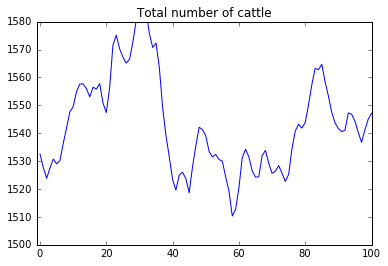

In [9]:
TotalStock = Econ1.k[0] + g*Econ1.k[1] + g*Econ1.k[2] #Calculation of y_t
plt.plot(TotalStock)
plt.legend(loc='Best')
plt.ylim((1500,1580))
plt.xlim((-1,100))
plt.title('Total number of cattle')

In Figure 3 of their paper, RMS1994 plot the impulse response functions of consumption and the breeding stock of cattle to the demand shock, $\tilde d_t$, under the three different values of $\rho_3$. We replicate Figure 3 below:

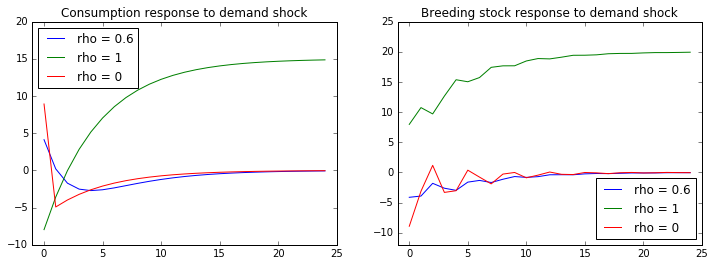

In [10]:
shock_demand = np.array([[0],[0],[1]])

Econ1.irf(ts_length=25,shock=shock_demand)
Econ2.irf(ts_length=25,shock=shock_demand)
Econ3.irf(ts_length=25,shock=shock_demand)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(Econ1.c_irf,label='rho = 0.6')
plt.plot(Econ2.c_irf,label='rho = 1')
plt.plot(Econ3.c_irf,label='rho = 0')
plt.legend(loc='Best')
plt.ylim((-10,20))
plt.xlim((-1,25))
plt.title('Consumption response to demand shock')

plt.subplot(122)
plt.plot(Econ1.k_irf[:,0],label='rho = 0.6')
plt.plot(Econ2.k_irf[:,0],label='rho = 1')
plt.plot(Econ3.k_irf[:,0],label='rho = 0')
plt.legend(loc='Best')
plt.ylim((-12,25))
plt.xlim((-1,25))
plt.title('Breeding stock response to demand shock')

The above plot shows that consumption patterns differ markedly, depending on the persistence of the demand shock: 

If it is purely transitory ($\rho_3 = 0$) then consumption rises immediately, but is later reduced to build stocks up again. 

If it is permanent ($\rho_3 = 1$), then consumption falls immediately, in order to build up stocks to satisfy the permanent rise in future demand.

In Figure 4 of their paper, RMS1994 plot the response to a demand shock of the breeding stock *and* the total stock, for $\rho_3 = 0$ and $\rho_3 = 0.6$. We replicate that Figure below:

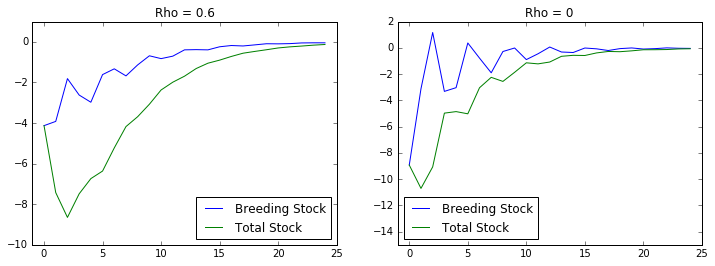

In [11]:
Total1_irf = Econ1.k_irf[:,0] + g*Econ1.k_irf[:,1] + g*Econ1.k_irf[:,2]
Total3_irf = Econ3.k_irf[:,0] + g*Econ3.k_irf[:,1] + g*Econ3.k_irf[:,2]

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(Econ1.k_irf[:,0],label='Breeding Stock')
plt.plot(Total1_irf,label='Total Stock')
plt.legend(loc='Best')
plt.ylim((-10,1))
plt.xlim((-1,25))
plt.title('Rho = 0.6')

plt.subplot(122)
plt.plot(Econ3.k_irf[:,0],label='Breeding Stock')
plt.plot(Total3_irf,label='Total Stock')
plt.legend(loc='Best')
plt.ylim((-15,2))
plt.xlim((-1,25))
plt.title('Rho = 0')

The "moving average" nature of the equation for $y_t$ creates a humped shape response of the total stock in response to demand shocks, causing the cyclicality seen in the first plot of this notebook.